In [19]:
import numpy as np
import scipy as sp
import pandas as pd
import scipy
import scipy.stats
from scipy.stats import norm
import math
import random
import matplotlib.pyplot as plt
import pickle
from EM import EM
from plot import plot
from scipy import linalg
from numpy import ma

### Data Generation

In [27]:
class Model:
    # num_tseries is the number of time series generated by Model, each is time_length long
    # missing is the probability of an observation missing, default to zero 
    def __init__(self, time_length, num_tseries, missing=0):
        self.T = time_length
        self.num_tseries = num_tseries
        # model parameters
        self.A = np.array([[-1.3, -.8]]) # the coefficients a_j's stored in a matrix
        self.b = np.array([1.5, .5])
        self.num_treatments = self.A.shape[1]
        self.num_chronic = self.b.shape[0]
        # noise are the variance, not standard deviation
        # noise for transition should be larger than noise for observation
        self.noise_0 = 3
        self.noise_1 = .4
        self.noise_2 = .1
        self.init_z = 1
        self.missing = missing
        # simulated data
        self.z = np.zeros((self.num_tseries, self.T))
        self.y = np.zeros((self.num_tseries, self.T))
        self.X = np.zeros((self.num_tseries, self.T, self.num_treatments))
        self.c = np.zeros((self.num_tseries, self.num_chronic))
        self.pi = np.zeros((self.num_tseries, self.T))
        
    def set_X(self, n):
        for t in range(self.T):
            self.X[n, t, :] = np.random.binomial(n=1, p=0.3, size=self.A.shape[1])# np.random.randint(2, size = self.num_treatments)

    def set_c(self, n):
        self.c[n, :] = np.random.binomial(n=1, p=0.5, size=self.num_chronic)#np.random.randint(2, size = self.num_chronic)
        
    def transition(self, prev):
        z = np.random.normal(prev, np.sqrt(self.noise_1), 1)
        return z

    def emission(self, z, n, t):
        treatment_effect = 0
        for j in range(np.shape(self.A)[0]):
            if t-1 >= j:
                treatment_effect += np.dot(self.A[j, :], self.X[n, t-1-j, :])
        pi = treatment_effect + np.dot(self.b, self.c[n, :]) # total added effect
        prob = np.random.uniform(0, 1, 1)
        # to simulate time series we are dealing with, the first and last observations are not missing
        if prob < self.missing and t > 0 and t != self.T-1:
            y = np.nan
        else:
            mean = z + pi
            y = np.random.normal(mean, np.sqrt(self.noise_2), 1)
        return y, pi
    
    def pct_missing(self, n):
        pct = np.shape(np.where(np.isnan(self.y[n, :]))[0])[0]/self.T*100
        print('missing {}% of observations'.format(pct))
    
    # generate a single trajectory indexed n
    def gen_trajectory(self, n):
        self.set_X(n)
        self.set_c(n)
        self.z[n, 0] = np.random.normal(self.init_z, np.sqrt(self.noise_0), 1)
        self.y[n, 0], self.pi[n, 0] = self.emission(self.z[n, 0], n, 0)
        for t in range(1, self.T):
            self.z[n, t] = self.transition(self.z[n, t-1])
            self.y[n, t], self.pi[n, t] = self.emission(self.z[n, t], n, t)
    
    # plot the trajectory indexed n
    def plot_trajectory(self, n):
        times = list(range(self.T))
        fig = plt.figure()
        plt.plot(times, self.y[n, :], label = 'observed')
        plt.plot(times, self.z[n, :], label = 'counterfactual')
        for t in np.nonzero(self.X[n, :, :])[0]:
            plt.axvline(x=t, color='g', linestyle='--')
        plt.xlabel('time (hr)')
        plt.ylabel('INR')
        plt.title('Simulated trajectory')
        plt.legend()
        fig.set_figheight(8)
        fig.set_figwidth(15)
        plt.show()
    
    # generate and plot multiple trajectories 
    def run_simulation(self):
        np.random.seed(0)
        for n in range(self.num_tseries):
            self.gen_trajectory(n)
            #self.plot_trajectory(n)
            #self.pct_missing(n)

In [28]:
%%capture
model = Model(10, 50, 0.0)
model.run_simulation()

In [29]:
%%time
em = EM(model.y, model.X, model.c, model.A.shape[0], 0, train_pct = 1)
num_iter = em.run_EM(10000)

iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
iteration 75
iteration 76
iteration 77
iteratio

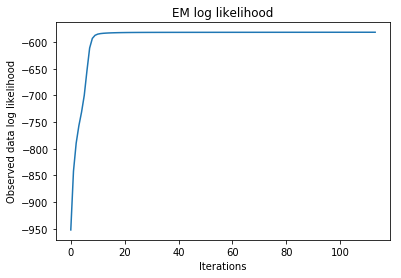

In [30]:
time = [i for i in range(len(em.obs_log_lik))]
plt.plot(time, em.obs_log_lik)
#plt.axhline(y=log_lik_true_param, color='r')
plt.xlabel('Iterations')
plt.ylabel('Observed data log likelihood')
plt.title('EM log likelihood')
plt.show()

In [31]:
def mapd(actual, pred):
    return np.average(np.abs((actual-pred)/actual)) * 100

print('estimated A: {}'.format(em.A))
print('true A: {}'.format(model.A))
print('mean absolute percentage difference of A: {}'.format(mapd(model.A, em.A)))
print('estimated b: {}'.format(em.b))
print('true b: {}'.format(model.b))
print('mean absolute percentage difference of b: {}'.format(mapd(model.b, em.b)))
print('estimated initial state mean: {}'.format(em.init_z))
print('true initial state mean: {}'.format(model.init_z))
print('mean absolute percentage difference of initial state mean: {}'.format(mapd(model.init_z, em.init_z)))
print('estimated sigma_0: {}'.format(em.sigma_0))
print('true sigma_0: {}'.format(model.noise_0))
print('mean absolute percentage difference of initial state variance: {}'.format(mapd(model.noise_0, em.sigma_0)))
print('estimated sigma_1: {}'.format(em.sigma_1))
print('true sigma_1: {}'.format(model.noise_1))
print('mean absolute percentage difference of transition variance: {}'.format(mapd(model.noise_1, em.sigma_1)))
print('estimated sigma_2: {}'.format(em.sigma_2))
print('true sigma_2: {}'.format(model.noise_2))
print('mean absolute percentage difference of observation variance: {}'.format(mapd(model.noise_2, em.sigma_2)))
print('estimated ratio: {}'.format(em.sigma_1/em.sigma_2))
print('true ratio: {}'.format(model.noise_1/model.noise_2))

estimated A: [[-1.28191801 -0.75143657]]
true A: [[-1.3 -0.8]]
mean absolute percentage difference of A: 3.730675402318534
estimated b: [2.04218959 0.50404127]
true b: [1.5 0.5]
mean absolute percentage difference of b: 18.477113231176983
estimated initial state mean: 0.752271087786074
true initial state mean: 1
mean absolute percentage difference of initial state mean: 24.7728912213926
estimated sigma_0: 1.9178943422921233
true sigma_0: 3
mean absolute percentage difference of initial state variance: 36.07018859026256
estimated sigma_1: 0.29100225688115194
true sigma_1: 0.4
mean absolute percentage difference of transition variance: 27.249435779712016
estimated sigma_2: 0.13096408615621816
true sigma_2: 0.1
mean absolute percentage difference of observation variance: 30.96408615621815
estimated ratio: 2.2220004386090637
true ratio: 4.0


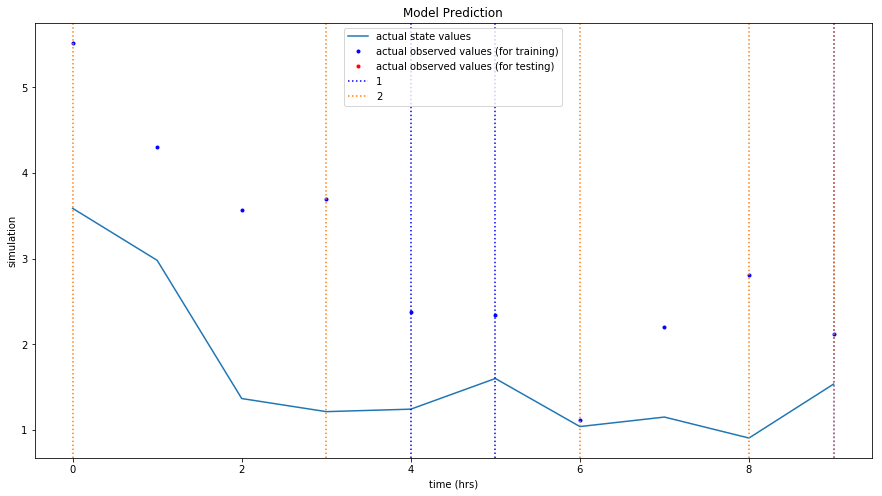

Patient 1


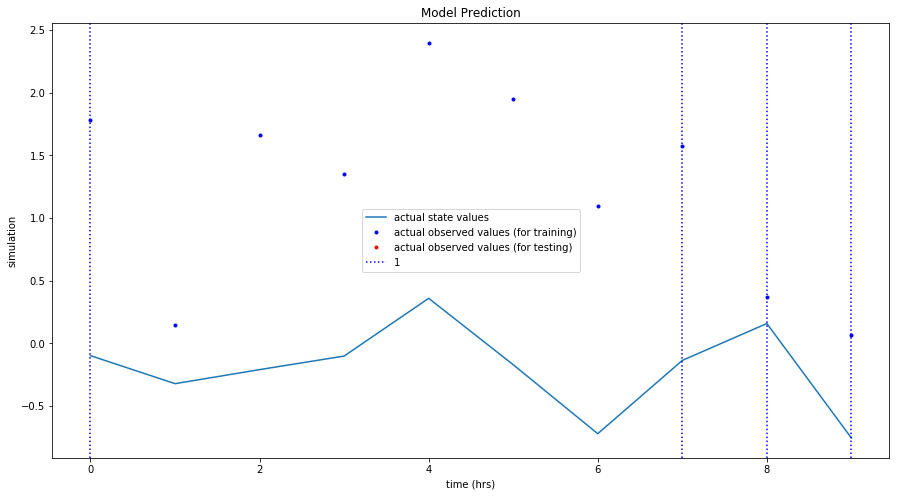

Patient 2


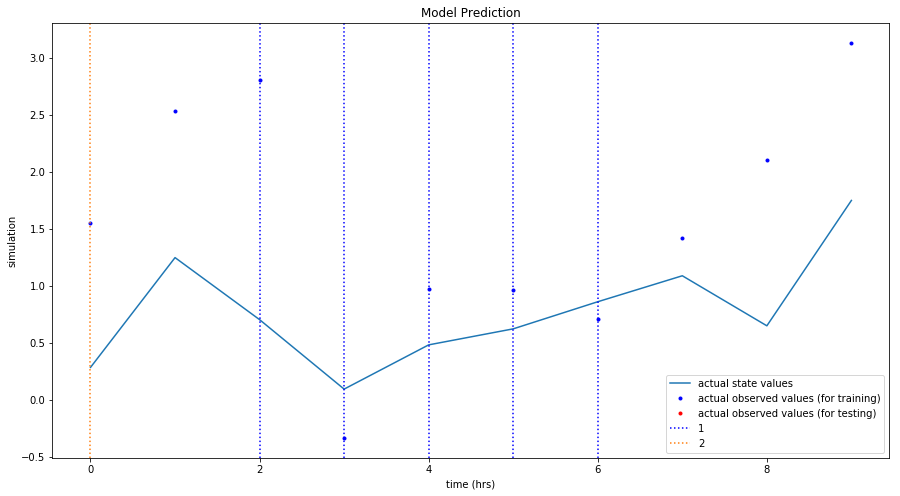

Patient 3


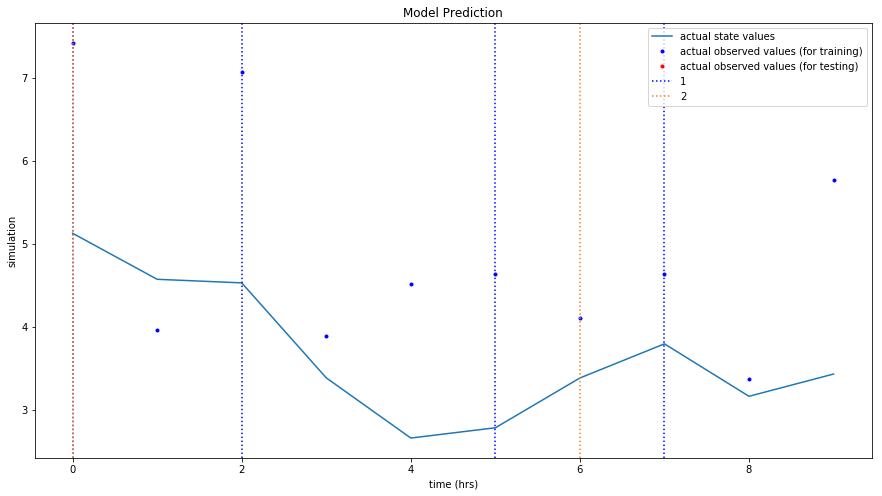

Patient 4


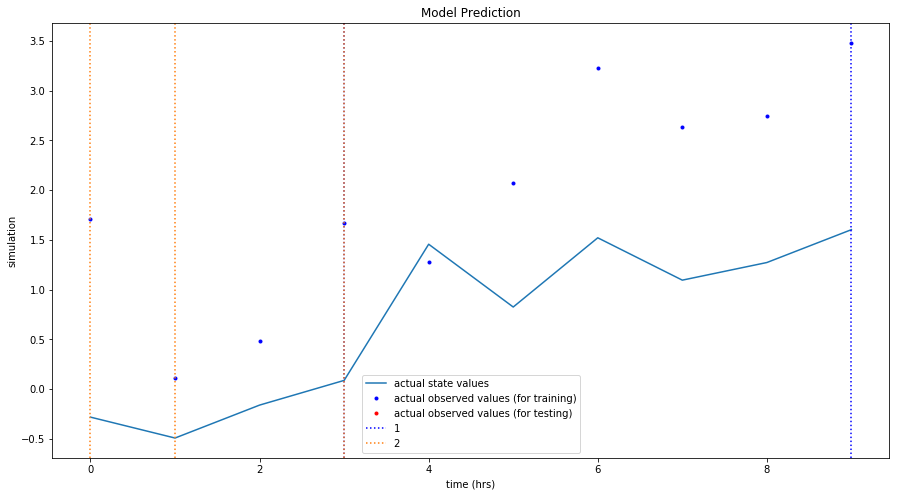

Patient 5


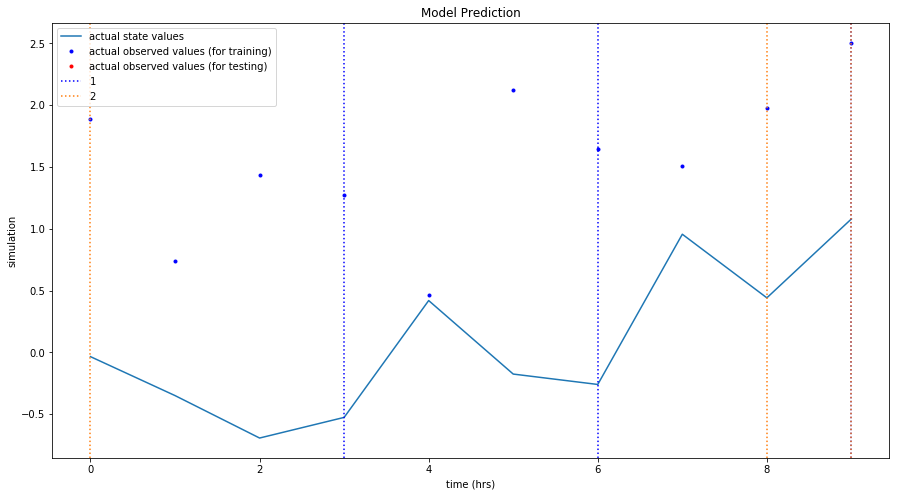

Patient 6


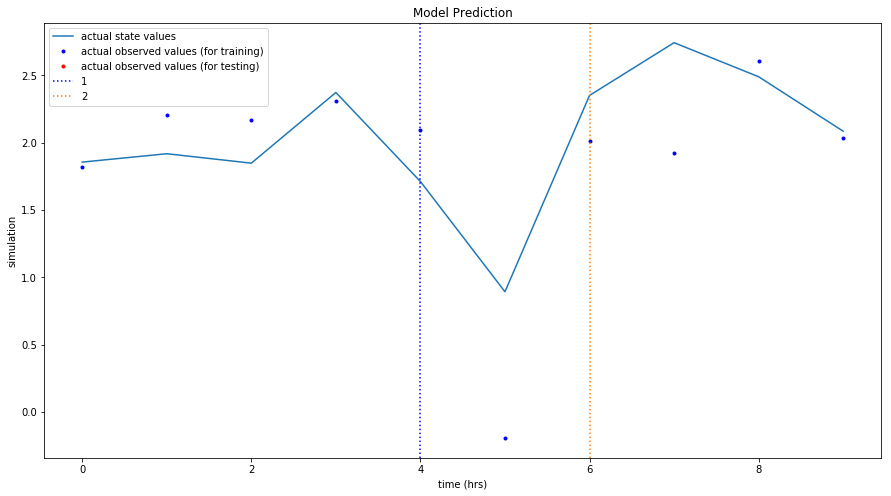

Patient 7


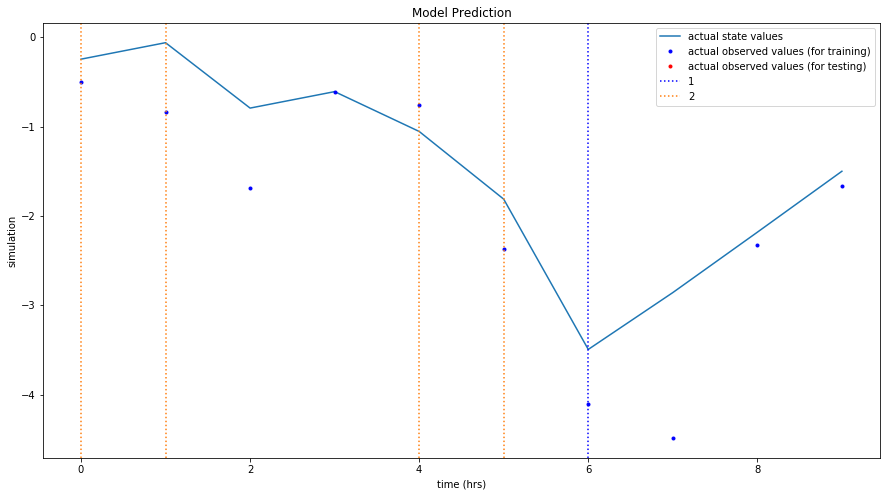

Patient 8


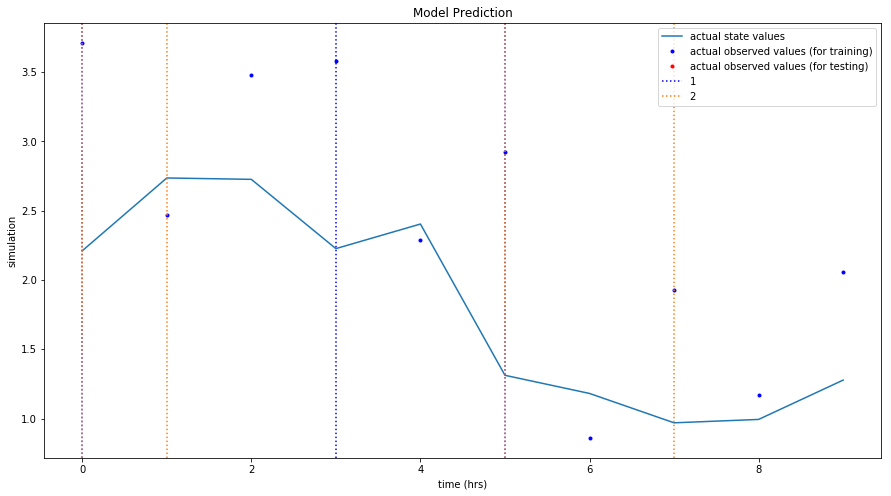

Patient 9


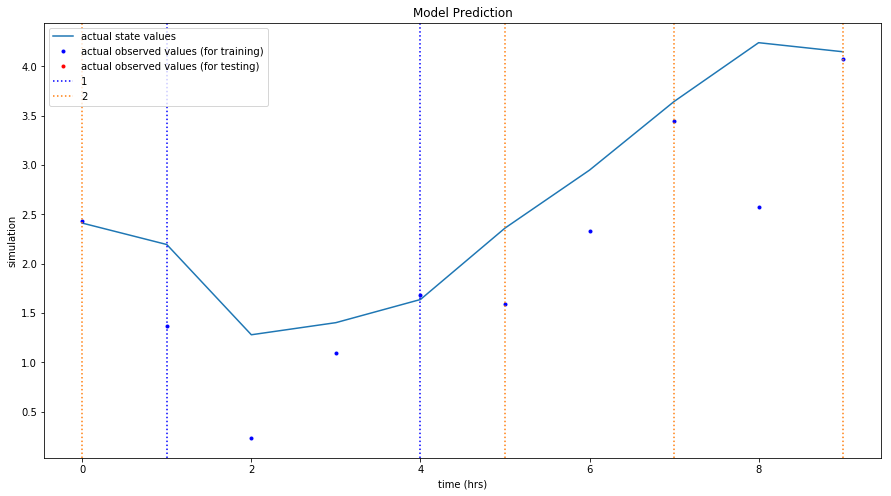

In [32]:
for n in range(10):
    plot(em, n, time_unit=1, true_model=True, model=model, signal_name='simulation', treatment_types=['1', '2'])

In [13]:
print('initial state variance initialization: {}'.format(round(em.init_0, 5)))
print('chronic initialization: {}'.format(np.round(em.init_b, 5)))
print('estimated initial state variance: {}'.format(round(em.sigma_0, 5)))
print('estimated chronic: {}'.format(np.round(em.b, 5)))

initial state variance initialization: 3e-05
chronic initialization: [-0.00056]
estimated initial state variance: 10.94962
estimated chronic: [15.05518]


In [14]:
%%time
initial_b = [-5, -3, 0, 3, 5, 7, 9, 11, 13, 15, 19]
initial_sigma_0 = [.0001]
results = []
for sigma in initial_sigma_0:
    for b in initial_b:
        em = EM(model.y, model.X, model.c, model.A.shape[0], 0, train_pct = 1, single_effect=False, init_A_given=True, init_A=np.zeros_like(model.A),
                init_b_given=True, init_b=np.full_like(model.b, b, dtype=np.float), init_0=sigma, init_1=1, init_2=.01, init_state=6)#, X_prev_given=True, X_prev=X_prev)
        num_iter = em.run_EM(20000)
        results.append([em.init_0, em.init_b, em.sigma_0, em.b])

iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
iteration 75
iteration 76
iteration 77
iteratio

iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
41 iterations before params converge
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
37 iterations before params converge
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteratio

In [15]:
results

[[0.0001, array([-5.]), 8.772415424777396, array([11.81387612])],
 [0.0001, array([-3.]), 8.765440428747226, array([11.86410965])],
 [0.0001, array([0.]), 8.759089331482944, array([11.92040979])],
 [0.0001, array([3.]), 8.755339425847067, array([11.96315302])],
 [0.0001, array([5.]), 8.753598864301983, array([11.98769687])],
 [0.0001, array([7.]), 0.002487554463883157, array([11.87559106])],
 [0.0001, array([9.]), 0.001622525441486573, array([11.88718715])],
 [0.0001, array([11.]), 0.0012300640250360573, array([11.89925729])],
 [0.0001, array([13.]), 0.0011980846426116899, array([11.92280246])],
 [0.0001, array([15.]), 0.001515670395971398, array([11.94042615])],
 [0.0001, array([19.]), 0.0035183171040726793, array([11.98131032])]]

In [18]:
for row in results:
    print(np.round(row[3][0],4))

11.8139
11.8641
11.9204
11.9632
11.9877
11.8756
11.8872
11.8993
11.9228
11.9404
11.9813


* Randomly initialize both

initial state variance initialization: 0.00027
chronic initialization: [-0.00556]
estimated initial state variance: 0.05306
estimated chronic: [10.24031]

initial state variance initialization: 0.0151
chronic initialization: [0.00779]
estimated initial state variance: 0.09462
estimated chronic: [9.9564]

initial state variance initialization: 0.00747
chronic initialization: [0.02621]
estimated initial state variance: 0.09458
estimated chronic: [9.95682]

initial state variance initialization: 0.00923
chronic initialization: [-0.00298]
estimated initial state variance: 25.78226
estimated chronic: [0.03472]

initial state variance initialization: 0.01051
chronic initialization: [-0.00099]
estimated initial state variance: 0.09463
estimated chronic: [9.95636]

* set sigma 0 = .001. change b initialization

ValueError: x and y must have same first dimension, but have shapes (0,) and (66,)

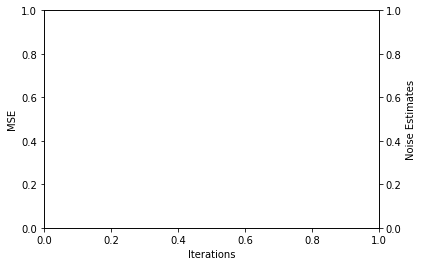

In [8]:
fig, ax1 = plt.subplots()
time = [i for i in range(len(em.mse))]
#ax1.plot(time, em.mse, label='MSE', color='r')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('MSE')

ax2 = ax1.twinx()
ax2.set_ylabel('Noise Estimates')
ax2.plot(time, em.params[em.A.shape[1]+em.b.shape[0]+1], label='sigma 0')
ax2.axhline(y=model.noise_2, color='g', linestyle=':', label='true value')

plt.legend()
plt.show()

In [ ]:
fig, ax1 = plt.subplots()
time = [i for i in range(len(em.mse))]
ax1.plot(time, em.mse, label='MSE', color='r')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('MSE')

ax2 = ax1.twinx()
ax2.set_ylabel('Coefficient Estimates')
color = ['m', 'y']
for i in range(em.A.shape[1]):
    ax2.plot(time, em.params[i], label='Coefficient A {}'.format(i+1))
    ax2.axhline(y=model.A[0, i], linestyle=':', label='true value coeffient A {}'.format(i+1), color=color[i])
for i in range(em.A.shape[1], em.A.shape[1]+em.b.shape[0]):
    ax2.plot(time, em.params[i], label='Coeffient b {}'.format(i+1-em.A.shape[1]))
    ax2.axhline(y=model.b[i-em.A.shape[1]], linestyle=':', label='true value coeffient b')
#for i in range(em.A.shape[1]+em.b.shape[0], len(em.params.keys())):
#    plt.plot(time,)
plt.legend()
plt.show()

In [ ]:
fig, ax1 = plt.subplots()
time = [i for i in range(len(em.mse))]
ax1.plot(time, em.mse, label='MSE', color='r')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('MSE')

ax2 = ax1.twinx()
ax2.set_ylabel('Noise Estimates')
ax2.plot(time, em.params[len(em.params.keys())-1], label='sigma 2')
ax2.axhline(y=model.noise_2, color='g', linestyle=':', label='true value')
plt.legend()
plt.show()

In [ ]:
fig, ax1 = plt.subplots()
time = [i for i in range(len(em.mse))]
ax1.plot(time, em.mse, label='MSE', color='r')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('MSE')

ax2 = ax1.twinx()
ax2.set_ylabel('Noise Estimates')
ax2.plot(time, em.params[em.A.shape[1]+em.b.shape[0]+2], label='sigma 1')
ax2.axhline(y=model.noise_1, color='g', linestyle=':', label='true value')

plt.legend()
plt.show()

In [ ]:
fig, ax1 = plt.subplots()
time = [i for i in range(len(em.mse))]
ax1.plot(time, em.mse, label='MSE', color='r')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('MSE')

ax2 = ax1.twinx()
ax2.set_ylabel('Initial state mean Estimates')
ax2.plot(time, em.params[em.A.shape[1]+em.b.shape[0]], label='initial state mean')
ax2.axhline(y=model.init_z, color='g', linestyle=':', label='true value')

plt.legend()
plt.show()

In [ ]:
em.obs_log_lik

In [ ]:
time = [i for i in range(len(em.expected_log_lik))]
plt.plot(time, em.expected_log_lik)
#plt.axhline(y=log_lik_true_param, color='r')
plt.xlabel('Iterations')
plt.ylabel('Expected data log likelihood')
plt.title('EM expected log likelihood')
plt.show()

In [ ]:
%%capture
# to debug loglik
for i in range(0):
    model = Model(20, 1, 0.3)
    model.run_simulation()
    em = EM(model.y, model.X, model.c, model.A.shape[0], 0, train_pct = 1, single_effect=False)
    num_iter = em.run_EM(5000)
    #loglik_increase = all([em.expected_log_lik[j] <= em.expected_log_lik[j+1] for j in range(len(em.expected_log_lik)-1)])
    loglik_increase = all([em.obs_log_lik[j] <= em.obs_log_lik[j+1] for j in range(len(em.obs_log_lik)-1)])
    if not loglik_increase:
        break

In [ ]:
i

In [ ]:
time = [i for i in range(len(em.obs_log_lik))]
plt.plot(time, em.obs_log_lik)
#plt.axhline(y=log_lik_true_param, color='r')
plt.xlabel('Iterations')
plt.ylabel('Observed data log likelihood')
plt.title('EM log likelihood')
plt.show()

In [ ]:
#measurements = ma.asarray(model.y)
#measurements[:, np.where(np.isnan(model.y[0, :]))[0]] = ma.masked
measurements = ma.asarray(model.y)
measurements[:, np.where(np.isnan(model.y[0, :]))[0]] = ma.masked

In [ ]:
from pykalman import KalmanFilter
X = np.transpose(measurements)
kf = KalmanFilter(transition_matrices = 1, observation_matrices = 1, initial_state_covariance=em.init_0, initial_state_mean=em.init_state, transition_covariance=em.init_1, observation_covariance=em.init_2)
kf = kf.em(X, n_iter=num_iter, em_vars=['initial_state_mean', 'initial_state_covariance', 'transition_covariance', 'observation_covariance'])

time = [i for i in range(len(kf.loglik))]
plt.plot(time, kf.loglik)
#plt.axhline(y=log_lik_true_param, color='r')
plt.xlabel('Iterations')
plt.ylabel('Observed data log likelihood')
plt.title('pykalman log likelihood')
plt.show()

In [ ]:
all([kf.loglik[j] <= kf.loglik[j+1] for j in range(len(kf.loglik)-1)])

In [ ]:
kf.initial_state_covariance[0][0]

In [ ]:
em.sigma_0

In [ ]:
kf.initial_state_mean[0]

In [ ]:
em.init_z

In [ ]:
kf.transition_covariance[0][0]

In [ ]:
em.sigma_1

In [ ]:
kf.observation_covariance[0][0]

In [ ]:
em.sigma_2

### Last Observation Carry Forward

In [ ]:
# assume the first observation is not nan and the data array is not entirely nan
def LBCF(data):
    filled = np.zeros(data.shape)
    for n in range(data.shape[0]):
        for i, y in enumerate(data[n, :]):
            if np.isnan(y):
                filled[n, i] = filled[n, i-1]
            else:
                filled[n, i] = y
    return filled

### Notes on the current model

1. Identifying coefficients is still somewhat challenging (often off by a little), especially when the noises are larger.
2. When the coefficients are too small i.e. closer to the noise value, the model is unable to recover them.
3. The model has trouble identifying the noise values.  

sigma_filter appears to converge to a value for all t > $t_0$. This replicates the updates equations, where y represents sigma_pred, x represents kgain, z represents sigma_filter. Following iterations, z always converges to one of the roots of the polynomial z^2 + a*z -a*b.